# Testing Randomness

**Spatial Pooler and Temporal Model** all have a random initialization.  
In this notebook will test to which amount `random state` can affect our results.  
For this purpose, a univariate model should be enough.

In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt 
import mu
# from tqdm import tqdm_notebook
# import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data
Load Data and Groundtruth labels:

In [4]:
PATH_relative = 'realKnownCause/machine_temperature_system_failure.csv'

In [8]:
df = pd.read_csv('../data/NAB/' + PATH_relative) #parse_dates=True
with open('../data/NAB/labels/combined_windows.json') as f:
    labels = json.loads(f.read())

In [9]:
df[0:5]

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


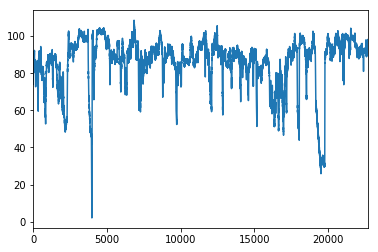

In [10]:
df.value.plot()

In [11]:
df['value'] = pd.to_numeric(df['value'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")

Groundtruth labels for anomaly

In [12]:
labels[PATH_relative]

[[u'2013-12-10 06:25:00.000000', u'2013-12-12 05:35:00.000000'],
 [u'2013-12-15 17:50:00.000000', u'2013-12-17 17:00:00.000000'],
 [u'2014-01-27 14:20:00.000000', u'2014-01-29 13:30:00.000000'],
 [u'2014-02-07 14:55:00.000000', u'2014-02-09 14:05:00.000000']]

In [13]:
df['labels'] = np.zeros_like(df.value)

# set values within the range = 1
for i in range(len(labels[PATH_relative])):
    df.loc[(df['timestamp'] >= labels[PATH_relative][i][0]) & 
           (df['timestamp'] <= labels[PATH_relative][i][1]), 'labels'] = 1

In [14]:
df[0:5]

,timestamp,value,labels
0,2013-12-02 21:15:00,73.967322,0.0
1,2013-12-02 21:20:00,74.935882,0.0
2,2013-12-02 21:25:00,76.124162,0.0
3,2013-12-02 21:30:00,78.140707,0.0
4,2013-12-02 21:35:00,79.329836,0.0


In [15]:
data = df.to_dict(orient='records')
data[0:5]

[{'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:15:00'),
  'value': 73.96732207},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:20:00'),
  'value': 74.93588199999998},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:25:00'),
  'value': 76.12416182},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:30:00'),
  'value': 78.14070732},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:35:00'),
  'value': 79.32983574}]

## HTM Model

In [16]:
from nupic.frameworks.opf.common_models.cluster_params import getScalarMetricWithTimeOfDayAnomalyParams
from nupic.encoders.scalar import ScalarEncoder
from nupic.algorithms.spatial_pooler import SpatialPooler
from nupic.algorithms.backtracking_tm import BacktrackingTM
from nupic.algorithms.anomaly_likelihood import AnomalyLikelihood

In [17]:
from nupic.multivariate_modules import utils

ImportError: No module named multivariate_modules

In [18]:
def computeRawAnomalyScore(activeColumns, prevPredictedColumns):
  """Computes the raw anomaly score.

  The raw anomaly score is the fraction of active columns not predicted.

  :param activeColumns: array of active column indices
  :param prevPredictedColumns: array of columns indices predicted in prev step
  :returns: anomcaly score 0..1 (float)
  """
  nActiveColumns = len(activeColumns)
  if nActiveColumns > 0:
    # Test whether each element of a 1-D array is also present in a second
    # array. Sum to get the total # of columns that are active and were
    # predicted.
    score = np.in1d(activeColumns, prevPredictedColumns).sum()
    # Get the percent of active columns that were NOT predicted, that is
    # our anomaly score.
    score = (nActiveColumns - score) / float(nActiveColumns)
  else:
    # There are no active columns.
    score = 0.0

  return score

In [19]:
modelParams = [getScalarMetricWithTimeOfDayAnomalyParams(df['value'],
                                                        minVal=df['value'].min(), 
                                                        maxVal=df['value'].max()
                                                       )]

We build:  
- 1x 'ScalarEncoder' which encodes the field `value`

We won't encode the field `timestamp` in this experiment.

### ModelParams

In [39]:
varsName = [0]

In [40]:
varsName

[0]

In [41]:
encoders = {}
i = 0
minVal = df['value'].min()
maxVal = df['value'].max()
encoders['value'] = ScalarEncoder( 
    w=21, minval=minVal, maxval=maxVal,
    resolution=modelParams[varsName[0]]['modelConfig']['modelParams']['sensorParams']['encoders']['c1']['resolution']
    )

In [42]:
for i in xrange(len(data)):
    data[i]['inputSDR'] = encoders['value'].encode(data[i]['value'])

In [43]:
print "len(inputSDR): ", len(data[0]['inputSDR'])
print data[0]
print len(data)

len(inputSDR):  151
{'timestamp': Timestamp('2013-12-02 21:15:00'), 'labels': 0.0, 'value': 73.96732207, 'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)}
22695


**SP:**

In [44]:
selectedSPparams = {
    u'boostStrength': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['boostStrength'],
#     u'columnCount': 2048,
    u'globalInhibition': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['globalInhibition'],
#     u'inputWidth': 0,
    u'numActiveColumnsPerInhArea': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['numActiveColumnsPerInhArea'],
    u'potentialPct': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['potentialPct'],
#    u'seed': 1956,
    u'spVerbosity': 0,
#     u'spatialImp': u'cpp',
    u'synPermActiveInc': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['synPermActiveInc'],
    u'synPermConnected': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['synPermConnected'],
    u'synPermInactiveDec': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['synPermInactiveDec'],
   ### Changes
    u'inputDimensions': (len(data[0]['inputSDR']), ),
    u'columnDimensions': modelParams[varsName[0]]['modelConfig']['modelParams']['spParams']['columnCount'], 
}

**TM**:

In [45]:
selectedTMparams = { 
    'activationThreshold': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['activationThreshold'],
    'cellsPerColumn': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['cellsPerColumn'],
#     'columnCount': 2048,
    'globalDecay': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['globalDecay'],
    'initialPerm': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['initialPerm'],
#     'inputWidth': 2048,
    'maxAge': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['maxAge'],
    'maxSegmentsPerCell': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['maxSegmentsPerCell'],
    'maxSynapsesPerSegment': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['maxSynapsesPerSegment'],
    'minThreshold': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['minThreshold'],
    'newSynapseCount': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['newSynapseCount'],
    'outputType': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['outputType'],
    'permanenceDec': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['permanenceDec'],
    'permanenceInc': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['permanenceInc'],
#     'predictedSegmentDecrement': 0.001,
#    'seed': 1960,
#     'temporalImp': 'tm_cpp',
    'verbosity': 0,
    ### Changes
    'numberOfCols': modelParams[varsName[0]]['modelConfig']['modelParams']['tmParams']['columnCount'],

}

In [20]:
def idx_active_cols(inputArr):
    """
    This function takes an 1d or nd-array and returns a 1d-array with the index for ACTIVE bits/columns: 
    
    Parameters
    ----------
    inputArr:   np.array (1d or nD)
            
    Output
    ------
    tmActiveColsIdx: 1d np.arraz
        Array with index of active cols.
        
    """
    #tmObject.reshape(tmObject.numberOfCols, tm.cellsPerColumn)
    activeColsVec = []  # initialize vector

    for i in range(inputArr.shape[0]):
        # assign 1 if any 1 (active cell) in the column,
        # 0 otherwise
        if np.any(inputArr[i]>0):
        # if np.any(tm.compute(spSDR[track[3]['sp_active']], enableLearn=True, enableInference=True).reshape(256, 3)[i]>0):
            activeColsVec.append(1)
        else:
            activeColsVec.append(0)
    # return index of active Columns        
    tmActiveColsIdx = np.flatnonzero(np.array(activeColsVec))
    return tmActiveColsIdx

In [21]:
anomalyLikelihood = AnomalyLikelihood()

In [22]:
seeds = np.random.randint(1, 1000, 10).tolist()
seeds

[31, 736, 923, 923, 724, 959, 115, 176, 389, 119]

In [23]:
data[0]

{'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 'labels': 0.0,
 'timestamp': Timestamp('2013-12-02 21:15:00'),
 'value': 73.96732207}

In [24]:
import time

In [45]:
start_time = time.clock()

experiment = []

for seed in seeds:
    result = []
    temp = {}
    seed = seed
    sp = SpatialPooler(seed=seed, **selectedSPparams)
    tm = BacktrackingTM(seed=seed, **selectedTMparams)
  # Print SP
    cols = []
    connections = []
    for col in xrange(sp.getColumnDimensions()):
        connected = np.zeros(len(data[0]['inputSDR']), dtype="int")
        sp.getConnectedSynapses(col, connected)
        cols.append(col)
        connections.append(connected)

    spSDR = dict(zip(cols, connections))

    for i in xrange(5):
    # Save all the SP-columns active for every input
        output = np.zeros(sp.getColumnDimensions(), dtype="int")
        sp.compute(data[i]['inputSDR'], learn=False, activeArray=output)
        sp_active = idx_active_cols(output) #save to dict
    # for every input, select the 'sp_active' col and get active bit in very col  
        sp4tm = [spSDR.get(cols) for cols in sp_active]
        # stack all the arrays in matrix and sum to see overlap 
        sp4tm = sum(np.array(sp4tm))
        # if overlap 1 send active cols aove 
        sp4tm[sp4tm>0] = 1
    # Send each vector to the TP, with learning turned off
        tm.compute(sp4tm, enableLearn=True, enableInference=True)
        anomalyScore = computeRawAnomalyScore(idx_active_cols(tm.infActiveState['t']), idx_active_cols(tm.cellConfidence['t-1']))
        likelihood = anomalyLikelihood.anomalyProbability(data[i]['value'], anomalyScore, data[i]['timestamp'])
        logLikelihood = anomalyLikelihood.computeLogLikelihood(likelihood)
        lh = likelihood    
        logLH = logLikelihood
    ## Anomaly Attribution
        # check overlapping columns
        idxOverlap = np.in1d(idx_active_cols(tm.infActiveState['t']), idx_active_cols(tm.cellConfidence['t-1']))
        # shows actual active column that do not overalp with prediction
        idxAS = idx_active_cols(tm.infActiveState['t'])[idxOverlap == False].tolist()
        
        temp = {'AnomalyScore': anomalyScore, 'idxAS': idxAS, 'lh':lh, 'logLH':logLH, 'seed':seed}
        result.append(temp)
    experiment.append(result)
    
end_time = time.clock() 
print (end_time - start_time), "seconds"
print (end_time - start_time)/60, "mins"

21.560097 seconds
0.35933495 mins


In [1]:
import copy
dataOut = copy.deepcopy(data)

In [48]:
filename = 'rndmInintTEST_univ.json'
with open(filename, 'w') as f:
    json.dump(experiment, f, indent=4, sort_keys=True, separators=(',', ': '))